# 1. Preprocessing

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, TargetEncoder
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.impute import KNNImputer
from sklearn.metrics import log_loss, classification_report, confusion_matrix


In [82]:
df = pd.read_csv('/Users/melaniedaddio/Desktop/Cours_M2/M2_S2/scoring/Churn_contrat_auto/data/processed/df_cleaned.csv')

/var/folders/74/x3782kls1rv6qscx40xcj5rm0000gn/T/ipykernel_49791/4179772364.py:1: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/melaniedaddio/Desktop/Cours_M2/M2_S2/scoring/Churn_contrat_auto/data/processed/df_cleaned.csv')


In [83]:
df.head()

,code_usage_auto,code_agent,code_formule,code_produit_gestion,prime_annuelle_ttc,code_marque_vehicule,libelle_modele_vehicule,numero_tarif,puissance_fiscale,rang_valeur_vehicule,...,code_marque_vehicule_groupe_1,numero_tarif_groupe,numero_tarif_groupe2,code_csp_groupe_1,code_csp_groupe_2,situation_familiale_binaire,region_groupe,etat_groupe,motif_resiliation_groupe,rang_valeur_vehicule_groupe
0,611.0,A00104,R,4190A,1929.66,PEUGEOT,205,BL050,D,5.0,...,tres_repandue,tres_courant_BL050,BL050,AUTRES,rare,marie,RA,ACTIF,motif_rare,Low
1,636.0,A00104,C,4190A,4106.44,PEUGEOT,309,BL064,K,10.0,...,tres_repandue,tres_courant_BL064,BL064,AUTRES,rare,marie,RA,ACTIF,motif_rare,Medium
2,611.0,A00104,C,4190A,4821.80,PEUGEOT,104,BL100,W,4.0,...,tres_repandue,modere,BL100,AUTRES,rare,marie,RA,ACTIF,motif_rare,Low
3,611.0,A00104,C,4190A,9460.74,RENAULT,CLIO,BL100,K,10.0,...,tres_repandue,modere,BL100,AUTRES,rare,non_marie,RA,ACTIF,motif_rare,Medium
4,603.0,A00104,S,4190A,1530.09,MERCEDES,300D 12313010,BL064,G,15.0,...,moyenne,tres_courant_BL064,BL064,AUTRES,rare,marie,RA,ACTIF,motif_rare,High


In [84]:
# Suppression des variables magiques
df = df.drop(columns=["etat","etat_groupe", "client_actif", "motif_resiliation", "motif_resiliation_groupe"])

In [85]:
le = LabelEncoder()
df["contrat"]= le.fit_transform(df["contrat"])

In [86]:
df[["contrat"]]

,contrat
0,0
1,0
2,0
3,0
4,0
...,...
90242,0
90243,0
90244,0
90245,0


## 1.1 Discretisation des variables continues 

Cela peut permettre de capter les liens non linéaires qui peuvent exister entre la variable explicative continue et la variable cible. Cela est surtout pour notre modèle de regression logistique; Pour les modèles à base d'arbre cela n'est pas nécessairemebt utile puisque par construction, ils feront eux-mêmes les découpages (i.e. la discrétisation). Néanmoins, cela peut rester intéressant

In [ ]:
# Pas forcement nécessaire de le faire peut améliorer notre modèle mais prend du temps

## 1.2 Préparation à la modélisation

### 1.2.1 Séparation Apprentissage/test/validation (70% / 15% / 15%)

⚠️ faire attention au desiquilibre de la variable cible 

In [143]:
# Étape 1 : split train (70%) vs temp (30%)
df_train, df_temp = train_test_split(
    df, test_size=0.3, stratify=df["contrat"], random_state=42
)

# Étape 2 : split temp -> validation (15%) et test (15%)
df_val, df_test = train_test_split(
    df_temp, test_size=0.5, stratify=df_temp["contrat"], random_state=42
)

In [144]:
target = "contrat"
features = [col for col in df.columns if col != target]

# Pour l'entraînement
x_train = df_train[features]
y_train = df_train[target]

# Pour la validation
x_val = df_val[features]
y_val = df_val[target]

# Pour le test final
x_test = df_test[features]
y_test = df_test[target]


In [145]:
# aficher les tailles des ensembles
print(f"x_train {x_train.shape}")
print(f"x_val {x_val.shape}")
print(f"x_test{x_test.shape}")
print(f"y_train {y_train.shape}")
print(f"y_val {y_val.shape}")
print(f"y_test{y_test.shape}")

x_train (63172, 71)
x_val (13537, 71)
x_test(13538, 71)
y_train (63172,)
y_val (13537,)
y_test(13538,)


⚠️ ATTENTION pour la normalisation, valeurs manquantes et encodage (target encoding) : 
- Sur train : on fit + transform. => Parce que c’est l'entraînement qui découvre la structure des données (on entraîne le modèle dessus)
- Sur test (ou validation) : on transform uniquement, jamais fit. => Parce que c’est l'entraînement qui découvre la structure des données (on entraîne le modèle dessus)

In [90]:
df.columns

Index(['code_usage_auto', 'code_agent', 'code_formule', 'code_produit_gestion',
       'prime_annuelle_ttc', 'code_marque_vehicule', 'libelle_modele_vehicule',
       'numero_tarif', 'puissance_fiscale', 'rang_valeur_vehicule',
       'nb_sinistres_2_ans_non_resp', 'nb_sinistres_3_ans_non_resp',
       'nb_sinistres_1_an_non_resp', 'nb_sinistres_0_an_non_resp',
       'nb_sinistres_3_ans_resp', 'nb_sinistres_2_ans_resp',
       'nb_sinistres_1_an_resp', 'nb_sinistres_0_an_resp',
       'niveau_bonus_malus', 'prime_reference', 'code_marche',
       'nb_contrats_resilies', 'code_csp', 'sexe', 'situation_familiale',
       'departement', 'region', 'nb_contrats_actifs',
       'nb_contrats_actifs_auto', 'nb_contrats_actifs_habitation',
       'nb_contrats_actifs_divers', 'nb_contrats_actifs_sante',
       'nb_contrats_actifs_vie', 'nb_contrats_auto_resilies',
       'nb_contrats_habitation_resilies', 'nb_contrats_sante_resilies',
       'nb_contrats_vie_resilies', 'nb_contrats_divers_resil

In [91]:
var_date = ['date_debut_contrat_converted', 'date_dernier_mouvement_converted',
       'date_obtention_permis_converted', 'date_mise_circulation_converted',
       'date_naissance_converted', 'anciennete_client_converted',
       'echeance_contrat_mmjj']
len(var_date)

7

In [92]:
var_num = [
       'prime_annuelle_ttc', 
       'nb_sinistres_2_ans_non_resp', 'nb_sinistres_3_ans_non_resp',
       'nb_sinistres_1_an_non_resp', 'nb_sinistres_0_an_non_resp',
       'nb_sinistres_3_ans_resp', 'nb_sinistres_2_ans_resp',
       'nb_sinistres_1_an_resp', 'nb_sinistres_0_an_resp',
       'niveau_bonus_malus', 'prime_reference',
       'nb_contrats_resilies', 'nb_contrats_actifs',
       'nb_contrats_actifs_auto', 'nb_contrats_actifs_habitation',
       'nb_contrats_actifs_divers', 'nb_contrats_actifs_sante',
       'nb_contrats_actifs_vie', 'nb_contrats_auto_resilies',
       'nb_contrats_habitation_resilies', 'nb_contrats_sante_resilies',
       'nb_contrats_vie_resilies', 'nb_contrats_divers_resilies', 'score_u',
       'coefficient_commission', 'coefficient_profil_tarif', 'crm',
       'age_au_debut', 
       'age_optention_permis', 
       'delai_dernier_mouvement']

len(var_num)

30

In [93]:
var_cat = ['code_agent',
 'code_formule',
 'code_produit_gestion',
 'code_marque_vehicule',
 'libelle_modele_vehicule',
 'numero_tarif',
 'puissance_fiscale',
 'code_marche',
 'code_csp',
 'sexe',
 'situation_familiale',
 'departement',
 'region',
 'rang_valeur_vehicule',
 'code_usage_auto_groupe',
 'libelle_modele_vehicule_groupe_1',
 'libelle_modele_vehicule_groupe_2',
 'code_agent_groupe',
 'code_formule_groupe',
 'code_produit_gestion_groupe',
 'code_marque_vehicule_groupe_2',
 'code_marque_vehicule_groupe_1',
 'numero_tarif_groupe',
 'numero_tarif_groupe2',
 'code_csp_groupe_1',
 'code_csp_groupe_2',
 'situation_familiale_binaire',
 'region_groupe',
 'rang_valeur_vehicule_groupe',
 'code_usage_auto',
 'premier_contrat',
 'age_avant_mise_circulation',
 'permis_avant_contrat',
 'vehicule_avant_contrat']

len(var_cat)

34

### 1.2.2 Normalisation des variables continues 

La normalisation des variables continues est utile seulement dans le cas du modèle de regression logistique (surtout si l'ont fait une regularisation par la suite -> ce qui est notre cas). Pour les modèles à base d'arbre ce n'est pas utile car c'est basé sur une méthode de découpe et non de distance.

De plus il est aussi necessaire que nous la fassions car nous allons effectuer un traitement des valeur manquantes des variables continues à l'aide des KNN et il est necessaire que nos variables soient normalisées.

In [94]:
# Standar scaler 
# attention faire fit sur train et transform sur train et test

In [95]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train[var_num])
x_test_scaled = scaler.transform(x_test[var_num])
x_val_scaled = scaler.transform(x_val[var_num])

### 1.2.3 Traitement des valeurs manquantes 

Pour les variables continues il est souvent judicieux de faire les KNN (attention normaliser les données avant de faire un KNN). Pour les variables catégorielles remplacer par une modalité "unknow". 

#### 1.2.3.1 variables catégorielles

In [96]:
# Remplacer les valeurs manquantes des variables catégorielles par "missing"
for col in var_cat:
    x_train[col] = x_train[col].fillna("missing").astype(str)
    x_test[col] = x_test[col].fillna("missing").astype(str)
    x_val[col] = x_val[col].fillna("missing").astype(str)

/var/folders/74/x3782kls1rv6qscx40xcj5rm0000gn/T/ipykernel_49791/508327260.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train[col] = x_train[col].fillna("missing").astype(str)
/var/folders/74/x3782kls1rv6qscx40xcj5rm0000gn/T/ipykernel_49791/508327260.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[col] = x_test[col].fillna("missing").astype(str)
/var/folders/74/x3782kls1rv6qscx40xcj5rm0000gn/T/ipykernel_49791/508327260.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy 

#### 1.2.3.2 variables continues

In [97]:
# Imputation KNN
imputer = KNNImputer(n_neighbors=5)
x_train_imputed = imputer.fit_transform(x_train_scaled)
x_test_imputed = imputer.transform(x_test_scaled)
x_val_imputed = imputer.transform(x_val_scaled)

In [104]:
x_train_imputed_df = pd.DataFrame(x_train_imputed, columns=var_num, index=x_train.index)
x_val_imputed_df = pd.DataFrame(x_val_imputed, columns=var_num, index=x_val.index)
x_test_imputed_df = pd.DataFrame(x_test_imputed, columns=var_num, index=x_test.index)

### 1.2.4 Encodage

Bien regarder apres analyse si on peut reunir certaines modalités ensembles. Puis : 
- Pour les variables à moins de 5 modalité faire one hot encoding ou order encoding (s'il y a un ordre)
- Pour les variables à plus de 5 modalité faire CatBoost encoder (TargetEncoder)
_Pour les 

#### 1.2.4.1 Pour les variables à plus de 5 modalité faire CatBoost encoder (TargetEncoder)

In [98]:
var_plus_5_modalities = df[var_cat].nunique()[df[var_cat].nunique() > 5].index.tolist()
var_plus_5_modalities

['code_agent',
 'code_formule',
 'code_produit_gestion',
 'code_marque_vehicule',
 'libelle_modele_vehicule',
 'numero_tarif',
 'puissance_fiscale',
 'code_csp',
 'situation_familiale',
 'departement',
 'region',
 'rang_valeur_vehicule',
 'libelle_modele_vehicule_groupe_1',
 'code_formule_groupe',
 'code_marque_vehicule_groupe_2',
 'numero_tarif_groupe2',
 'code_csp_groupe_1',
 'region_groupe',
 'code_usage_auto']

In [99]:
# Encodage CatBoostEncoder sur les variables à plus de 5 modalités
te = TargetEncoder()

x_train_te = pd.DataFrame(
    te.fit_transform(x_train[var_plus_5_modalities], y_train),
    columns=var_plus_5_modalities,
    index=x_train.index
)
x_val_te = pd.DataFrame(
    te.transform(x_val[var_plus_5_modalities]),
    columns=var_plus_5_modalities,
    index=x_val.index
)
x_test_te = pd.DataFrame(
    te.transform(x_test[var_plus_5_modalities]),
    columns=var_plus_5_modalities,
    index=x_test.index
)

x_train_te.head()


,code_agent,code_formule,code_produit_gestion,code_marque_vehicule,libelle_modele_vehicule,numero_tarif,puissance_fiscale,code_csp,situation_familiale,departement,region,rang_valeur_vehicule,libelle_modele_vehicule_groupe_1,code_formule_groupe,code_marque_vehicule_groupe_2,numero_tarif_groupe2,code_csp_groupe_1,region_groupe,code_usage_auto
50171,0.129449,0.074808,0.112304,0.122398,0.141053,0.115547,0.119775,0.080917,0.135186,0.104219,0.113841,0.124502,0.141053,0.074808,0.122398,0.115547,0.080917,0.113841,0.137925
83663,0.097964,0.129846,0.112289,0.140986,0.172807,0.157736,0.145261,0.134299,0.135424,0.081395,0.107160,0.131288,0.111565,0.129846,0.140986,0.157736,0.129560,0.107160,0.122844
25741,0.070653,0.075052,0.112289,0.123349,0.144867,0.157736,0.124137,0.109078,0.135424,0.103495,0.110617,0.114305,0.144867,0.075052,0.123349,0.157736,0.109078,0.110617,0.122844
75952,0.084807,0.175852,0.112372,0.109239,0.248798,0.078622,0.119947,0.078265,0.103546,0.142118,0.118348,0.116764,0.109778,0.175852,0.109239,0.078622,0.078265,0.118348,0.065143
50331,0.111121,0.116578,0.112308,0.116008,0.129918,0.161592,0.124819,0.134654,0.137608,0.100069,0.112878,0.111244,0.129918,0.116578,0.116008,0.161592,0.129177,0.112878,0.124585


#### 1.2.4.2 Pour les variables à moins de 5 modalité faire one hot encoding ou order encoding (s'il y a un ordre)

In [100]:
var_moins_5_modalities = df[var_cat].nunique()[df[var_cat].nunique() <= 5].index.tolist()
var_moins_5_modalities

['code_marche',
 'sexe',
 'code_usage_auto_groupe',
 'libelle_modele_vehicule_groupe_2',
 'code_agent_groupe',
 'code_produit_gestion_groupe',
 'code_marque_vehicule_groupe_1',
 'numero_tarif_groupe',
 'code_csp_groupe_2',
 'situation_familiale_binaire',
 'rang_valeur_vehicule_groupe',
 'premier_contrat',
 'age_avant_mise_circulation',
 'permis_avant_contrat',
 'vehicule_avant_contrat']

In [101]:
# One-hot encoding pour les variables à moins de 5 modalités
x_train_ohe = pd.get_dummies(x_train[var_moins_5_modalities], drop_first=True).astype(int)
x_val_ohe = pd.get_dummies(x_val[var_moins_5_modalities], drop_first=True).astype(int)
x_test_ohe = pd.get_dummies(x_test[var_moins_5_modalities], drop_first=True).astype(int)

In [102]:
# Vérification :
len(var_plus_5_modalities) + len(var_moins_5_modalities) == len(var_cat)

True

In [105]:
# regrouper les variables continues normalisés aux variables catégorielles encodées
x_train_encoded = pd.concat([x_train_imputed_df, x_train_te, x_train_ohe], axis=1)
x_val_encoded = pd.concat([x_val_imputed_df, x_val_te, x_val_ohe], axis=1)
x_test_encoded = pd.concat([x_test_imputed_df, x_test_te, x_test_ohe], axis=1)


In [106]:
x_train_encoded.head()

,prime_annuelle_ttc,nb_sinistres_2_ans_non_resp,nb_sinistres_3_ans_non_resp,nb_sinistres_1_an_non_resp,nb_sinistres_0_an_non_resp,nb_sinistres_3_ans_resp,nb_sinistres_2_ans_resp,nb_sinistres_1_an_resp,nb_sinistres_0_an_resp,niveau_bonus_malus,...,numero_tarif_groupe_tres_courant_BL064,code_csp_groupe_2_rare,code_csp_groupe_2_tres_courant,situation_familiale_binaire_non_marie,rang_valeur_vehicule_groupe_Low,rang_valeur_vehicule_groupe_Medium,premier_contrat_1,age_avant_mise_circulation_1,permis_avant_contrat_1,vehicule_avant_contrat_1
50171,-0.086837,-0.326470,-0.324416,-0.350660,0.819400,-0.164157,-0.189294,0.712979,-0.214677,0.546075,...,1,0,1,1,1,0,1,0,1,1
83663,-0.727504,-0.326470,-0.324416,-0.350660,-0.312457,-0.164157,-0.189294,-0.218762,-0.214677,1.286768,...,0,1,0,1,1,0,0,0,0,0
25741,0.790262,-0.326470,-0.324416,-0.350660,-0.312457,-0.164157,0.858553,-0.218762,-0.214677,-0.503241,...,0,0,1,1,0,1,0,0,0,1
75952,-1.222786,-0.326470,-0.324416,-0.350660,-0.312457,-0.164157,-0.189294,-0.218762,-0.214677,-0.564966,...,0,0,1,0,0,1,1,0,0,0
50331,0.016268,2.617495,-0.324416,0.199713,-0.312457,-0.164157,-0.189294,-0.218762,0.687254,2.212635,...,0,1,0,1,0,1,1,0,0,0


# 2. Régression logistique

## 2.1 Selection de variables

Ce type de modèle contraireemnt aux modèles "d'arbres" nécessitent une selection de variables. Pour ce faire nous allons dans un prmeier temps se baser sur les variables qui nous ont paru pertinentes au cour de notre data exploration. Puis nous comparerons les selection de variables avec Lasso, Ridge et Elastic Net.

### 2.1.1 Sélection de variables à l'aide de stats models

In [126]:
var_app = x_train_encoded.columns.tolist()

In [127]:
from sklearn.linear_model import LogisticRegression

reg_log = LogisticRegression()
reg_log.fit(x_train_encoded,y_train)

y_train_predict_proba = reg_log.predict_proba(x_train_encoded)[:,1]
y_test_predict_proba = reg_log.predict_proba(x_test_encoded)[:,1]

table_coeff = pd.DataFrame()
table_coeff["Variable"]=var_app
table_coeff["Coefficient"] = reg_log.coef_[0]
print(table_coeff)

print("Intercept : " + str(reg_log.intercept_))

                              Variable  Coefficient
0                   prime_annuelle_ttc     0.358585
1          nb_sinistres_2_ans_non_resp     0.007530
2          nb_sinistres_3_ans_non_resp     0.072514
3           nb_sinistres_1_an_non_resp     0.149741
4           nb_sinistres_0_an_non_resp     0.096079
..                                 ...          ...
68  rang_valeur_vehicule_groupe_Medium     0.401595
69                   premier_contrat_1     0.672544
70        age_avant_mise_circulation_1    -0.222657
71              permis_avant_contrat_1    -1.948865
72            vehicule_avant_contrat_1    -0.519715

[73 rows x 2 columns]
Intercept : [-5.57866171]


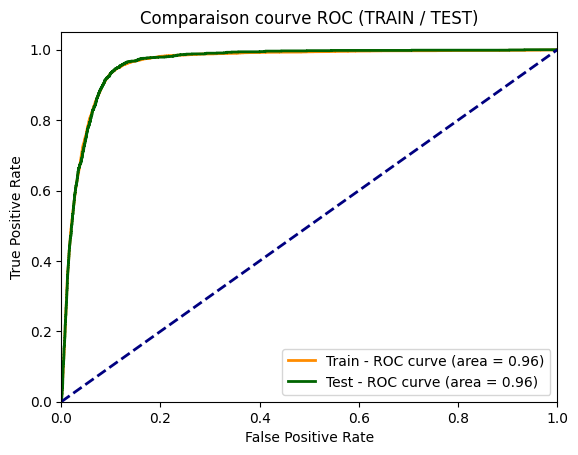

In [128]:
# Creation des courbes ROC
from sklearn.metrics import roc_curve, auc
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_predict_proba)
roc_auc_train = auc(fpr_train, tpr_train)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_predict_proba)
roc_auc_test = auc(fpr_test, tpr_test)

# Représentation graphique / courbe ROC
import matplotlib.pyplot as plt
plt.figure()
lw = 2
plt.plot(fpr_train, tpr_train, color='darkorange',
         lw=lw, label='Train - ROC curve (area = %0.2f)' % roc_auc_train)

plt.plot(fpr_test, tpr_test, color='darkgreen',
         lw=lw, label='Test - ROC curve (area = %0.2f)' % roc_auc_test)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparaison courve ROC (TRAIN / TEST)')
plt.legend(loc="lower right")
plt.show()

Le modèle complet avec regression logiste semble bien moins sur-apprendre que le modele complet avec XGBoost. 

La régression avec scikit learn ne donne pas d'information sur la pertinence des coefficients. Pour aller plus loin et détecter la pertinence des coefficients, nous allons utiliser le package statsmodels

In [129]:
import statsmodels as sm

from statsmodels.api import Logit

x_train_encoded["const"] =1
x_test_encoded["const"]=1 # pour ajouter l'intercept
lr = Logit(endog=y_train,exog=x_train_encoded)

reg = lr.fit()
print(reg.summary())

Optimization terminated successfully.
         Current function value: 0.167742
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                contrat   No. Observations:                63172
Model:                          Logit   Df Residuals:                    63099
Method:                           MLE   Df Model:                           72
Date:                Tue, 17 Jun 2025   Pseudo R-squ.:                  0.5224
Time:                        13:37:06   Log-Likelihood:                -10597.
converged:                       True   LL-Null:                       -22185.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
prime_annuelle_ttc                    

Les coefficients sont dits significatifs à 95% si la pvalue (P>|z|)<0.05. Dans ce cas, nous pouvons voir que des coefficients ne sont pas significatifs, il est pertinent de supprimer ces variables et de ré-apprendre le modèle

In [130]:
#Table variable avec pvalue
table_pvalue= pd.DataFrame(reg.pvalues,columns=["pvalue"])
print(table_pvalue)

                                    pvalue
prime_annuelle_ttc            1.662513e-14
nb_sinistres_2_ans_non_resp   9.779022e-01
nb_sinistres_3_ans_non_resp   4.876717e-02
nb_sinistres_1_an_non_resp    6.044855e-06
nb_sinistres_0_an_non_resp    5.030322e-03
...                                    ...
premier_contrat_1             1.301455e-61
age_avant_mise_circulation_1  6.265257e-01
permis_avant_contrat_1        2.092132e-25
vehicule_avant_contrat_1      7.532624e-18
const                         1.653221e-14

[74 rows x 1 columns]


In [131]:
#Selection des variables avec une pvalue <=0.05
var_train_reg = table_pvalue[table_pvalue["pvalue"]<0.05].index.values.tolist()
print(var_train_reg)

['prime_annuelle_ttc', 'nb_sinistres_3_ans_non_resp', 'nb_sinistres_1_an_non_resp', 'nb_sinistres_0_an_non_resp', 'nb_sinistres_1_an_resp', 'nb_sinistres_0_an_resp', 'prime_reference', 'nb_contrats_resilies', 'nb_contrats_actifs_auto', 'nb_contrats_actifs_habitation', 'nb_contrats_actifs_divers', 'nb_contrats_auto_resilies', 'nb_contrats_habitation_resilies', 'nb_contrats_sante_resilies', 'nb_contrats_vie_resilies', 'nb_contrats_divers_resilies', 'coefficient_commission', 'coefficient_profil_tarif', 'age_au_debut', 'age_optention_permis', 'delai_dernier_mouvement', 'code_agent', 'code_csp', 'rang_valeur_vehicule', 'libelle_modele_vehicule_groupe_1', 'code_usage_auto', 'code_marche_T', 'sexe_M', 'code_agent_groupe_rare', 'code_produit_gestion_groupe_AUTRES', 'numero_tarif_groupe_tres_courant_BL050', 'numero_tarif_groupe_tres_courant_BL064', 'rang_valeur_vehicule_groupe_Low', 'rang_valeur_vehicule_groupe_Medium', 'premier_contrat_1', 'permis_avant_contrat_1', 'vehicule_avant_contrat_1', 

In [132]:
# Relancer le modele avec seulement les variables significatives : 
lr = Logit(endog=y_train,exog=x_train_encoded[var_train_reg])

reg = lr.fit()
print(reg.summary())

Optimization terminated successfully.
         Current function value: 0.168567
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                contrat   No. Observations:                63172
Model:                          Logit   Df Residuals:                    63134
Method:                           MLE   Df Model:                           37
Date:                Tue, 17 Jun 2025   Pseudo R-squ.:                  0.5200
Time:                        13:37:07   Log-Likelihood:                -10649.
converged:                       True   LL-Null:                       -22185.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
prime_annuelle_ttc                         0.2883   

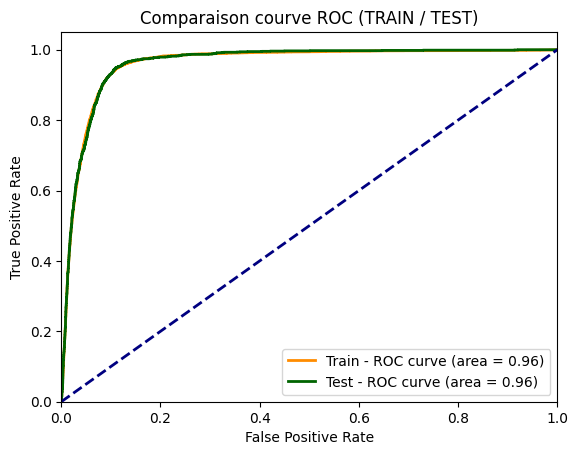

In [133]:
# Creation des courbes ROC
from sklearn.metrics import roc_curve, auc
fpr_train, tpr_train, _ = roc_curve(y_train, reg.predict(x_train_encoded[var_train_reg]))
roc_auc_train = auc(fpr_train, tpr_train)
fpr_test, tpr_test, _ = roc_curve(y_test, reg.predict(x_test_encoded[var_train_reg]))
roc_auc_test = auc(fpr_test, tpr_test)

# Représentation graphique / courbe ROC
import matplotlib.pyplot as plt
plt.figure()
lw = 2
plt.plot(fpr_train, tpr_train, color='darkorange',
         lw=lw, label='Train - ROC curve (area = %0.2f)' % roc_auc_train)

plt.plot(fpr_test, tpr_test, color='darkgreen',
         lw=lw, label='Test - ROC curve (area = %0.2f)' % roc_auc_test)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparaison courve ROC (TRAIN / TEST)')
plt.legend(loc="lower right")
plt.show()



In [134]:
reg_log = LogisticRegression(fit_intercept=True) # Pas d'intercept parce qu'il n'a pas été conservé précédement


del x_train_encoded["const"]
del x_test_encoded["const"]
if "const" in var_train_reg : 
    var_train_reg.remove("const")
    
reg_log.fit(x_train_encoded[var_train_reg],y_train)
y_train_predict_proba = reg_log.predict_proba(x_train_encoded[var_train_reg])[:,1]
y_test_predict_proba = reg_log.predict_proba(x_test_encoded[var_train_reg])[:,1]

table_coeff = pd.DataFrame()
table_coeff["Variable"]=var_train_reg
table_coeff["Coefficient"] = reg_log.coef_[0]
print(table_coeff)

print("Intercept : " + str(reg_log.intercept_))


                                  Variable  Coefficient
0                       prime_annuelle_ttc     0.285296
1              nb_sinistres_3_ans_non_resp     0.074680
2               nb_sinistres_1_an_non_resp     0.137578
3               nb_sinistres_0_an_non_resp     0.101717
4                   nb_sinistres_1_an_resp     0.326815
5                   nb_sinistres_0_an_resp     0.181795
6                          prime_reference    -0.248603
7                     nb_contrats_resilies     2.616024
8                  nb_contrats_actifs_auto    -1.183982
9            nb_contrats_actifs_habitation     0.165516
10               nb_contrats_actifs_divers     0.110155
11               nb_contrats_auto_resilies    -0.721978
12         nb_contrats_habitation_resilies    -1.668990
13              nb_contrats_sante_resilies    -1.000869
14                nb_contrats_vie_resilies    -0.139757
15             nb_contrats_divers_resilies    -1.707897
16                  coefficient_commission     0

In [135]:
table_coeff["Val_ABS_Coefficient"]=abs(table_coeff["Coefficient"])
table_coeff.sort_values(by =["Val_ABS_Coefficient"], inplace = True, ascending=False)
table_coeff.head(5)

,Variable,Coefficient,Val_ABS_Coefficient
24,libelle_modele_vehicule_groupe_1,3.885163,3.885163
22,code_csp,3.721562,3.721562
7,nb_contrats_resilies,2.616024,2.616024
25,code_usage_auto,2.092290,2.092290
35,permis_avant_contrat_1,-1.981362,1.981362


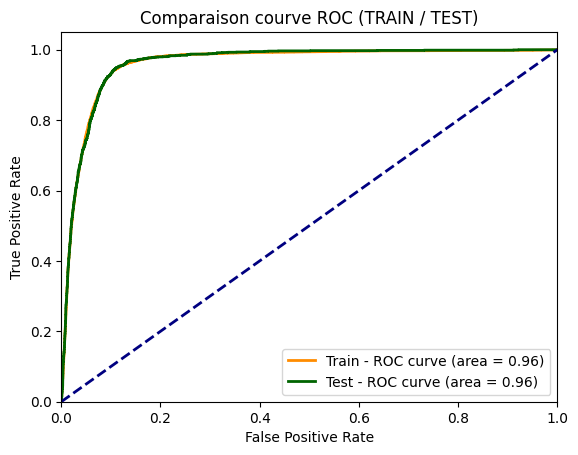

In [136]:
# Creation des courbes ROC
from sklearn.metrics import roc_curve, auc
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_predict_proba)
roc_auc_train = auc(fpr_train, tpr_train)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_predict_proba)
roc_auc_test = auc(fpr_test, tpr_test)

# Représentation graphique / courbe ROC
import matplotlib.pyplot as plt
plt.figure()
lw = 2
plt.plot(fpr_train, tpr_train, color='darkorange',
         lw=lw, label='Train - ROC curve (area = %0.2f)' % roc_auc_train)

plt.plot(fpr_test, tpr_test, color='darkgreen',
         lw=lw, label='Test - ROC curve (area = %0.2f)' % roc_auc_test)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparaison courve ROC (TRAIN / TEST)')
plt.legend(loc="lower right")
plt.show()

In [139]:
y_pred = reg_log.predict(x_test_encoded[var_train_reg])

              precision    recall  f1-score   support

           0       0.95      0.97      0.96     12018
           1       0.73      0.57      0.64      1520

    accuracy                           0.93     13538
   macro avg       0.84      0.77      0.80     13538
weighted avg       0.92      0.93      0.92     13538



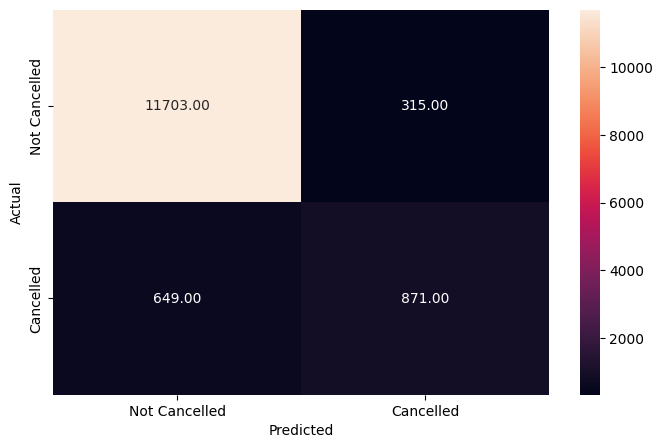

In [140]:
def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))

    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8,5))

    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels=['Not Cancelled', 'Cancelled'], yticklabels=['Not Cancelled', 'Cancelled'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

metrics_score(y_test, y_pred)

### 2.1.2 Selection de variables à l'aide de Lasso, Ridge et Elastic Net

In [119]:
from sklearn.linear_model import LogisticRegression
from skopt import BayesSearchCV
from skopt.space import Real, Integer,Categorical
from timeit import default_timer as timer

param_dict_bayes_elasticnet = {
    'penalty': Categorical(['elasticnet']), 
    'solver': Categorical(['saga']),
    'l1_ratio' : Real(0,0.99, prior='uniform'),
    'fit_intercept': Categorical([True,False]),
    'tol': Real(0,1, prior='uniform'),
    'C':Real(0,0.99, prior='uniform')}

param_dict_bayes_l1 = {
    'penalty': Categorical(['l1']), 
    'solver': Categorical(['liblinear','saga']),
    'fit_intercept': Categorical([True,False]),
    'tol': Real(0,1, prior='uniform'),
    'C':Real(0,0.9, prior='uniform')}

param_dict_bayes_l2 = {
    'penalty': Categorical(['l2']), 
    'solver': Categorical(['newton-cg', 'lbfgs','sag', 'saga']),
    'fit_intercept': Categorical([True,False]),
    'tol': Real(0,1, prior='uniform'),
    'C':Real(0,0.99, prior='uniform')}  


opt = BayesSearchCV(LogisticRegression(),[(param_dict_bayes_elasticnet,10),
                         (param_dict_bayes_l1,10),(param_dict_bayes_l2,10)],
                         cv=5,scoring = 'roc_auc')
                         
start = timer()  
opt.fit(x_train_encoded, y_train)
delais = timer()- start
best_param_opti_bayes =opt.best_params_
best_score_opti_bayes = opt.best_score_
all_result_opti_bayes = opt.cv_results_
print(" #### RECHERCHE DES PARAMETRES OPTIMAUX POUR LA REGRESSION LOGISTIQUE #### ")
print(" \n Durée de recherche en seconde :")
print(delais)
print("\n Paramètres optimaux : ")
best_param_opti_bayes =opt.best_params_
print(best_param_opti_bayes)
best_score_opti_bayes = opt.best_score_
print("\n Résultats  : " + str(best_score_opti_bayes))



 #### RECHERCHE DES PARAMETRES OPTIMAUX POUR LA REGRESSION LOGISTIQUE #### 
 
 Durée de recherche en seconde :
14.694318207999459

 Paramètres optimaux : 
OrderedDict({'C': 0.13926660668753232, 'fit_intercept': False, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.22190738935807347})

 Résultats  : 0.9540461241607161


In [120]:
reg_log = LogisticRegression(**opt.best_params_)
ref_log = LogisticRegression()
reg_log.fit(x_train_encoded,y_train)

table_coeff = pd.DataFrame()
table_coeff["Variable"]=var_app
table_coeff["Coefficient"] = reg_log.coef_[0]
print(table_coeff)

print("Intercept : " + str(reg_log.intercept_))

                              Variable  Coefficient
0                   prime_annuelle_ttc     0.098083
1          nb_sinistres_2_ans_non_resp     0.000000
2          nb_sinistres_3_ans_non_resp     0.074528
3           nb_sinistres_1_an_non_resp     0.137252
4           nb_sinistres_0_an_non_resp     0.102718
..                                 ...          ...
68  rang_valeur_vehicule_groupe_Medium    -0.086581
69                   premier_contrat_1     0.346973
70        age_avant_mise_circulation_1     0.000000
71              permis_avant_contrat_1    -1.351634
72            vehicule_avant_contrat_1    -0.571428

[73 rows x 2 columns]
Intercept : 0.0


In [121]:
y_pred = reg_log.predict(x_test_encoded)

              precision    recall  f1-score   support

           0       0.94      0.98      0.96     12018
           1       0.74      0.51      0.60      1520

    accuracy                           0.93     13538
   macro avg       0.84      0.74      0.78     13538
weighted avg       0.92      0.93      0.92     13538



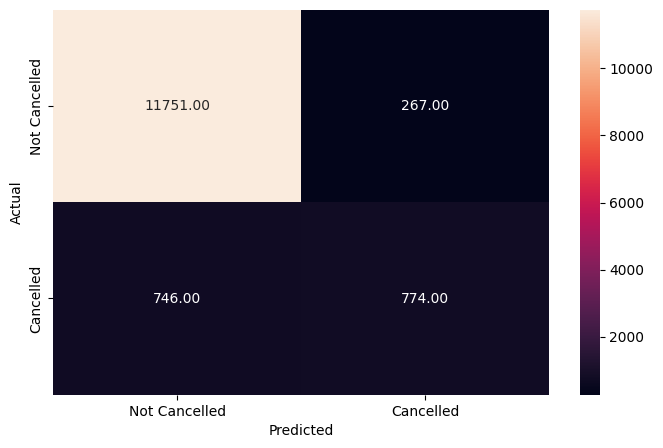

In [ ]:
metrics_score(y_test, y_pred)

Le modèle avec selection de variables avec LASSO/RIDGE/ELASTICNET semble moins performant en terme de F1-score.

### 2.1.13 Sélection de variables à l'aide de : l'analyse exploratoire

Au vu de notre analyse exploratoire nous pouvons distinguer une liste de variables qui pourraient etre pertinentes : 

Pour se faire nous avons garder les variables qui ont un lien significatif avec la variable cible. Ensuite, parmis ces variables nous n'allons supprimer celles qui ont des liens entre elles en garder la plus liées à la variable cible.


In [146]:
var_cat_select = [
    "libelle_modele_vehicule",
    "code_agent",
    "numero_tarif",
    "code_formule",
    "vehicule_avant_contrat",
    "code_usage_auto", # v-cramer bas
    'code_csp', # v-cramer bas
    'permis_avant_contrat', # v-cramer bas
    "puissance_fiscale", # v-cramer bas
    'situation_familiale', # v-cramer bas
    "premier_contrat", # v-cramer bas
    "sexe" # v-cramer bas
]

In [149]:
var_num_select = ['nb_contrats_resilies',
 'nb_contrats_actifs_auto',
 'nb_contrats_auto_resilies',
 #'age_vehicule', # retirer cette variable car recréée en binaire et non utilisable
 'nb_contrats_divers_resilies',
 'nb_contrats_habitation_resilies',
 'niveau_bonus_malus',
 'nb_contrats_sante_resilies',
 'coefficient_profil_tarif',
 'prime_annuelle_ttc',
 'coefficient_commission',
 'age_au_debut',
 'nb_contrats_actifs_habitation',
 'nb_sinistres_1_an_resp',
 'nb_sinistres_0_an_resp',
 'nb_contrats_vie_resilies',
 'nb_sinistres_1_an_non_resp',
 'nb_contrats_actifs_vie',
 'nb_contrats_actifs_sante',
 'nb_sinistres_2_ans_resp']

In [150]:
# On ré_applique toutes les étatpes de traitemebnt de variables mais seulement sur les variables uqi nous interessent : 

# Étape 1 : split train (70%) vs temp (30%)
df_train, df_temp = train_test_split(
    df, test_size=0.3, stratify=df["contrat"], random_state=42
)

# Étape 2 : split temp -> validation (15%) et test (15%)
df_val, df_test = train_test_split(
    df_temp, test_size=0.5, stratify=df_temp["contrat"], random_state=42
)
target = "contrat"
features = [col for col in df.columns if col != target]

# Pour l'entraînement
x_train = df_train[features]
y_train = df_train[target]

# Pour la validation
x_val = df_val[features]
y_val = df_val[target]

# Pour le test final
x_test = df_test[features]
y_test = df_test[target]

# aficher les tailles des ensembles
print(f"x_train {x_train.shape}")
print(f"x_val {x_val.shape}")
print(f"x_test{x_test.shape}")
print(f"y_train {y_train.shape}")
print(f"y_val {y_val.shape}")
print(f"y_test{y_test.shape}")

# Normalisation : 
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train[var_num_select])
x_test_scaled = scaler.transform(x_test[var_num_select])
x_val_scaled = scaler.transform(x_val[var_num_select])

# Remplacer les valeurs manquantes des variables catégorielles par "missing"
for col in var_cat_select:
    x_train[col] = x_train[col].fillna("missing").astype(str)
    x_test[col] = x_test[col].fillna("missing").astype(str)
    x_val[col] = x_val[col].fillna("missing").astype(str)

# Imputation KNN
imputer = KNNImputer(n_neighbors=5)
x_train_imputed = imputer.fit_transform(x_train_scaled)
x_test_imputed = imputer.transform(x_test_scaled)
x_val_imputed = imputer.transform(x_val_scaled)
x_train_imputed_df = pd.DataFrame(x_train_imputed, columns=var_num_select, index=x_train.index)
x_val_imputed_df = pd.DataFrame(x_val_imputed, columns=var_num_select, index=x_val.index)
x_test_imputed_df = pd.DataFrame(x_test_imputed, columns=var_num_select, index=x_test.index)

# Encodage

# Encodage CatBoostEncoder sur les variables à plus de 5 modalités

var_plus_5_modalities = df[var_cat_select].nunique()[df[var_cat_select].nunique() > 5].index.tolist()
var_plus_5_modalities

te = TargetEncoder()

x_train_te = pd.DataFrame(
    te.fit_transform(x_train[var_plus_5_modalities], y_train),
    columns=var_plus_5_modalities,
    index=x_train.index
)
x_val_te = pd.DataFrame(
    te.transform(x_val[var_plus_5_modalities]),
    columns=var_plus_5_modalities,
    index=x_val.index
)
x_test_te = pd.DataFrame(
    te.transform(x_test[var_plus_5_modalities]),
    columns=var_plus_5_modalities,
    index=x_test.index
)

x_train_te.head()

# Encodage one hot encoding sur les variables à moins de 5 modalités
var_moins_5_modalities = df[var_cat_select].nunique()[df[var_cat_select].nunique() <= 5].index.tolist()
var_moins_5_modalities

x_train_ohe = pd.get_dummies(x_train[var_moins_5_modalities], drop_first=True).astype(int)
x_val_ohe = pd.get_dummies(x_val[var_moins_5_modalities], drop_first=True).astype(int)
x_test_ohe = pd.get_dummies(x_test[var_moins_5_modalities], drop_first=True).astype(int)

# regrouper les variables continues normalisés aux variables catégorielles encodées
x_train_encoded = pd.concat([x_train_imputed_df, x_train_te, x_train_ohe], axis=1)
x_val_encoded = pd.concat([x_val_imputed_df, x_val_te, x_val_ohe], axis=1)
x_test_encoded = pd.concat([x_test_imputed_df, x_test_te, x_test_ohe], axis=1)

x_train_encoded.head()

x_train (63172, 71)
x_val (13537, 71)
x_test(13538, 71)
y_train (63172,)
y_val (13537,)
y_test(13538,)


/var/folders/74/x3782kls1rv6qscx40xcj5rm0000gn/T/ipykernel_49791/3601391418.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train[col] = x_train[col].fillna("missing").astype(str)
/var/folders/74/x3782kls1rv6qscx40xcj5rm0000gn/T/ipykernel_49791/3601391418.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[col] = x_test[col].fillna("missing").astype(str)
/var/folders/74/x3782kls1rv6qscx40xcj5rm0000gn/T/ipykernel_49791/3601391418.py:45: SettingWithCopyWarning: 
A value is trying to be set on a

,nb_contrats_resilies,nb_contrats_actifs_auto,nb_contrats_auto_resilies,nb_contrats_divers_resilies,nb_contrats_habitation_resilies,niveau_bonus_malus,nb_contrats_sante_resilies,coefficient_profil_tarif,prime_annuelle_ttc,coefficient_commission,...,code_formule,code_usage_auto,code_csp,puissance_fiscale,situation_familiale,vehicule_avant_contrat_1,permis_avant_contrat_1,premier_contrat_1,sexe_M,sexe_missing
50171,-0.542568,-0.618615,-0.147444,-0.350364,-0.522000,0.546075,0.489583,0.387708,-0.086837,0.298611,...,0.074316,0.137261,0.082025,0.120957,0.136514,1,1,1,1,0
83663,-0.542568,-0.618615,-0.715352,0.089673,-0.522000,1.286768,1.203663,-2.142632,-0.727504,0.298611,...,0.135582,0.122669,0.132698,0.148565,0.136514,0,0,0,0,0
25741,-0.542568,-0.618615,-0.715352,0.529711,-0.137034,-0.503241,-0.224498,-1.450133,0.790262,0.298611,...,0.075333,0.123866,0.107870,0.122290,0.136670,1,0,0,0,0
75952,-0.542568,0.400010,0.136510,-0.350364,-0.522000,-0.564966,-0.224498,0.098800,-1.222786,0.298611,...,0.176270,0.062444,0.077920,0.118399,0.103975,0,0,1,1,0
50331,-0.542568,-0.618615,-0.715352,-0.350364,0.247932,2.212635,0.489583,-0.714997,0.016268,0.298611,...,0.119401,0.122669,0.132698,0.123237,0.136514,0,0,1,1,0


In [151]:
from sklearn.linear_model import LogisticRegression

reg_log = LogisticRegression()
reg_log.fit(x_train_encoded,y_train)

y_train_predict_proba = reg_log.predict_proba(x_train_encoded)[:,1]
y_test_predict_proba = reg_log.predict_proba(x_test_encoded)[:,1]


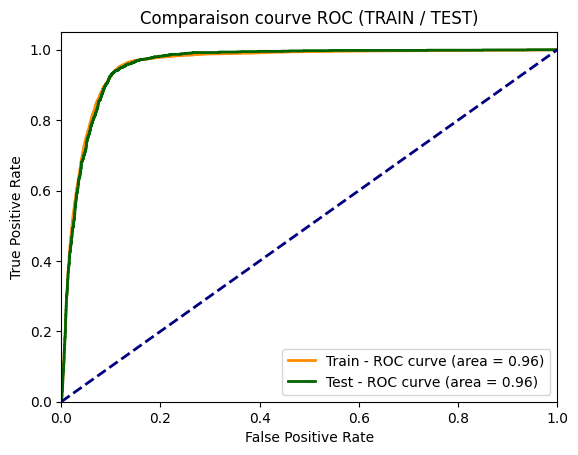

In [154]:
# Creation des courbes ROC
from sklearn.metrics import roc_curve, auc
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_predict_proba)
roc_auc_train = auc(fpr_train, tpr_train)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_predict_proba)
roc_auc_test = auc(fpr_test, tpr_test)

# Représentation graphique / courbe ROC
import matplotlib.pyplot as plt
plt.figure()
lw = 2
plt.plot(fpr_train, tpr_train, color='darkorange',
         lw=lw, label='Train - ROC curve (area = %0.2f)' % roc_auc_train)

plt.plot(fpr_test, tpr_test, color='darkgreen',
         lw=lw, label='Test - ROC curve (area = %0.2f)' % roc_auc_test)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparaison courve ROC (TRAIN / TEST)')
plt.legend(loc="lower right")
plt.show()

In [152]:
y_pred = reg_log.predict(x_test_encoded)

              precision    recall  f1-score   support

           0       0.94      0.97      0.96     12018
           1       0.71      0.54      0.61      1520

    accuracy                           0.92     13538
   macro avg       0.83      0.76      0.79     13538
weighted avg       0.92      0.92      0.92     13538



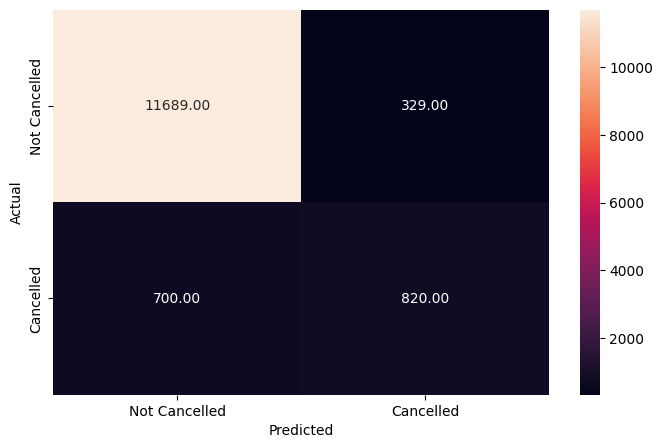

In [153]:
metrics_score(y_test, y_pred)

Sans optimiser le modèles c'est ce modele de regression logistique qui nous donne les meilleurs resultats

Au depart nous etions parti d'un mdoele tres complexe (XGBoost) basé sur les arbres. Ce modèle nous a permis de nous donner un premier apperçu des performances de notre modèle. Sands devoir necessairement perdre du temps sur la selection de variables, ni les traitement des valeurs manquantes ou la normalisation des valeurs continues. Cependant ce modèle donnait l'impression de sur apprendre avec des F1 score, precision est recall egaux à 1.

Maintenant que nous sommes reparti d'un model plus simple et interpretable (regression logistqiue) avec selection des variables, normalisation des variables continues et traitement des valeurs manquantes, nous nous approchons de résultats bien plus cohérents. Ce pednant ces resultats peuvent tout de meme etre améliorer.

Nous allons donc à present tenter de modéliser à nouveau un modèle basé sur les arbres. Nous aurions pu simplement faire un modèle d'arbre classqiue, cependant pour que ce dernier soit plus performant sans etre trop complexe et sur apprendre (comme le xgboost) nous avons choisi de faire un random forest. Nous nous attendions à que ce modèle soit le plus performant.

## 2.2 Optimisation